In [2]:
import math
import numpy as np
import quaternion
from skinematics import quat, rotmat, vector
from skinematics.sensors.manual import MyOwnSensor
import sqlite3

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# fetch data
path_to_db = ''
tablename = ''
id = 0

con = sqlite3.connect(path_to_db)
cur = con.cursor()
cur.execute('SELECT * FROM ' + tablename)
results = cur.fetchall()


cur.execute('SELECT * FROM recording_euler')
reference = cur.fetchall()

In [4]:
# organize data
data = {}
ids = []
# reference_values = []
# 0 -> id
# 1-3 -> acc
# 4-6 -> gyro
# 7-9 -> mag
# 10-12 -> euler
# 13 -> gen

for row in results:
    if row[0] in ids:
        data[row[0]]['acc'].append(row[1:4])
        data[row[0]]['gyr'].append(row[4:7])
        data[row[0]]['mag'].append(row[7:10])
    else:
        ids.append(row[0])
        data[row[0]] = {'acc': [], 'gyr': [], 'mag': []}
        data[row[0]]['acc'].append(row[1:4])
        data[row[0]]['gyr'].append(row[4:7])
        data[row[0]]['mag'].append(row[7:10])
                        

in_data = {'rate': 10,
          'acc': np.array(data[0]['acc']),
          'omega': np.array(data[0]['gyr']),
          'mag': np.array(data[0]['mag'])}

# convert the initial position to a rotation matrix 
Rx = rotmat.R('x', 0)
Ry = rotmat.R('y', 0)
Rz = rotmat.R('z', 0)

R_init = np.dot(Rz, np.dot(Ry, Rx))

In [5]:
# run filters for one sensor
sensor = MyOwnSensor(in_data=in_data, R_init=R_init, q_type='madgwick')

# analytical ('raw') orientation
q_mad = sensor.quat

# kalman
sensor = MyOwnSensor(in_data=in_data, R_init=R_init, q_type='kalman')
q_kal = sensor.quat

# madgwick
sensor = MyOwnSensor(in_data=in_data, R_init=R_init, q_type='analytical')
q_analytic = sensor.quat

Calculating the Quaternions [#########################] 1494/1494


In [6]:
# plot data
from matplotlib import pyplot as plt
import os

# generate x-axis
x = list(range(len(q_analytic)))
xticks = np.array(list(range(0, 40))) * 40
yticks = np.array(list(range(-9, 10))) * 10

roll_reference = []
roll_analytical = []
roll_kal = []
roll_mad = []

pitch_reference = []
pitch_analytical = []
pitch_kal = []
pitch_mad = []

yaw_reference = []
yaw_analytical = []
yaw_kal = []
yaw_mad = []

roll = []
pitch = []
yaw = []

for i, a in enumerate(q_analytic):  # TODO: Add complementary
    if i > 474:
        roll_reference.append(reference[i][1] - 50.5)
    else:
        roll_reference.append(reference[i][1] - 31.5)
    roll_analytical.append(a[0])
    roll_kal.append(q_kal[i][0])
    roll_mad.append(q_mad[i][0])
    roll.append([reference[i][1] - 31.5, a[0], q_kal[i][0], q_mad[i][0]])
    
    pitch_reference.append(reference[i][2] - 334)
    pitch_analytical.append(a[1])
    pitch_kal.append(q_kal[i][1])
    pitch_mad.append(q_kal[i][1])
    pitch.append([reference[i][2] - 334, a[1], q_kal[i][1], q_mad[i][1]])
    
    yaw_reference.append(reference[i][3] - 2)
    yaw_analytical.append(a[2])
    yaw_kal.append(q_kal[i][2])
    yaw_mad.append(q_mad[i][2])
    yaw.append([reference[i][3] - 2, a[2], q_kal[i][2], q_mad[i][2]])


Text(0.5,0,'Messpunkt [0.1s]')

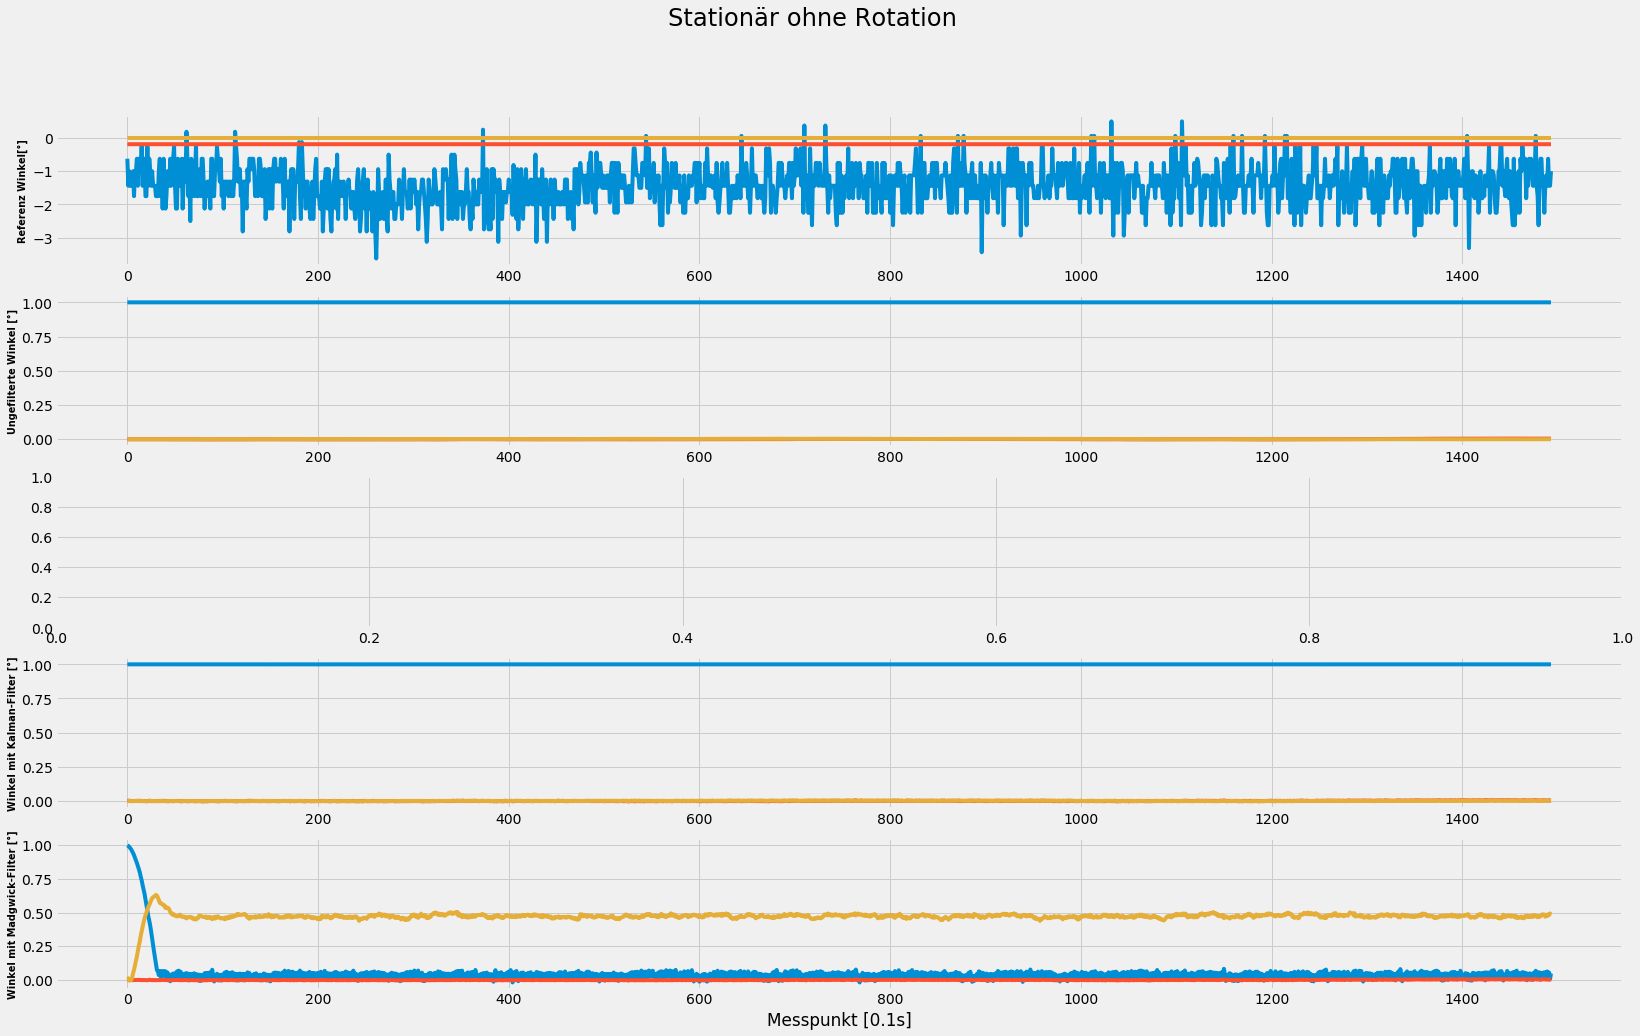

In [8]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(25,15))
p1 = fig.add_subplot(511)
p2 = fig.add_subplot(512)
p3 = fig.add_subplot(513)
p4 = fig.add_subplot(514)
p5 = fig.add_subplot(515)

fig.suptitle('Stationär ohne Rotation', fontsize='xx-large')

p1.plot(x, roll_reference)
p1.plot(x, pitch_reference)
p1.plot(x, yaw_reference)
p1.set_ylabel('Referenz Winkel[°]', fontsize='x-small', fontweight='bold')

p2.plot(x, roll_analytical)
p2.plot(x, pitch_analytical)
p2.plot(x, yaw_analytical)
p2.set_ylabel('Ungefilterte Winkel [°]', fontsize='x-small', fontweight='bold')

p4.plot(x, roll_kal)
p4.plot(x, pitch_kal)
p4.plot(x, yaw_kal)
p4.set_ylabel('Winkel mit Kalman-Filter [°]', fontsize='x-small', fontweight='bold')

p5.plot(x, roll_mad)
p5.plot(x, pitch_mad)
p5.plot(x, yaw_mad)
p5.set_ylabel('Winkel mit Madgwick-Filter [°]', fontsize='x-small', fontweight='bold')
p5.set_xlabel('Messpunkt [0.1s]')